# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам


# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**

### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo).

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
#import warnings
#warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)
​
Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).


In [3]:
from collections import deque
from itertools import islice

def sliding_window(iterable, size=2, step=1, fillvalue=None):
   # if size < 0 or step < 1:
   #     raise ValueError
    it = iter(iterable)
    q = deque(islice(it, size), maxlen=size)
    if not q:
        return  # empty iterable or size == 0
    q.extend(fillvalue for _ in range(size - len(q))) # pad to size
    while True:
        yield q  
     #   try:
     #       q.append(next(it))
     #       print(q)
     #   except StopIteration: # Python 3.5 pep 479 support
     #       return
        q.extend(next(it, fillvalue) for _ in range(step))
        if q[0] == None:
            return

In [4]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path,
                                    session_length=10, window_size=10):
    
    csv_files_list = glob(path_to_csv_files + '/*.csv')
    
    if type(site_freq_path) == str:
        with open(site_freq_path, 'rb') as f:
            site_freq = pickle.load(f)
    else:
        site_freq = site_freq_path
    
    site_freq.update({None : (0,0)})
        
    sites = [[] for x in range(session_length)]
    session_timespan = []
    unique_sites = []
    start_hour = []
    day_of_week = []
    user_ids = []  
    
    for csv_file in tqdm(csv_files_list):
        raw_data = pd.read_csv(csv_file, index_col='timestamp', parse_dates=['timestamp'])
        
        len_prev = len(sites[0])

        for sites_window in sliding_window(raw_data.site, session_length, window_size):
           # print(sites_window.index)
            for index, site in enumerate(sites_window):
                sites[index].append(site_freq[site][0])
            if sites_window[-1]==None:
                unique_sites.append(len(set(sites_window)) - 1)
            else:
                unique_sites.append(len(set(sites_window)))
            
        for time_window in sliding_window(raw_data.index, session_length, window_size):
            i = -1
            while True:
                try:
                    delta = time_window[i] - time_window[0]
                    break
                except TypeError:
                    i -= 1 
            session_timespan.append(delta.days * 86400 + delta.seconds)
            start_hour.append(time_window[0].hour)
            day_of_week.append(time_window[0].weekday())
        
        user_id = int(csv_file[len(path_to_csv_files) + 5:-4])
        user_ids = user_ids + (len(sites[0]) - len_prev) * [user_id]
        
    
    data_dict = dict() 
    cols = ['site' + str(x) for x in range(1, session_length+1)]       
    for index, col in enumerate(cols):
        data_dict.update({col : sites[index]})
    
    data_dict.update({'session_timespan' : session_timespan})
    data_dict.update({'unique_sites' : unique_sites})
    data_dict.update({'start_hour' : start_hour})
    data_dict.update({'day_of_week' : day_of_week})
    data_dict.update({'user_id' : user_ids})
    data = pd.DataFrame(data_dict)
                    
    return data

**Проверим функцию на игрушечном примере.**

In [5]:
train_data_toy = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '3users'), 
                                           os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'), 
                                           session_length=10, window_size=10)

In [6]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,unique_sites,start_hour,day_of_week,user_id
0,3,2,2,11,2,1,7,6,8,9,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,60,2,12,4,1
2,3,2,5,5,2,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,6,10,4,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [7]:
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                                               os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 
                                               session_length=10, window_size=10)

**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                                                os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'), 
                                                session_length=10, window_size=10)


Wall time: 11.6 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users[['session_timespan', 'unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', 'unique_sites', 'start_hour', 'day_of_week']]
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [10]:
print(np.median(train_data_10users.session_timespan), np.median(train_data_150users.session_timespan))

37.0 26.0


**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [11]:
print(np.median(train_data_10users.day_of_week), np.median(train_data_150users.day_of_week))

2.0 2.0


**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [12]:
print(np.median(train_data_10users.start_hour), np.median(train_data_150users.start_hour))

14.0 13.0


**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [13]:
print(np.median(train_data_10users.unique_sites), np.median(train_data_150users.unique_sites))

6.0 7.0


## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [14]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['user_name'] = train_data_10users['user_id'].map(id_name_dict)

In [15]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,unique_sites,start_hour,day_of_week,user_id,user_name
0,193,576,133,3,133,133,3,133,203,133,33,5,8,4,31,John
1,422,192,702,256,133,31,400,3561,217,55,284,10,8,4,31,John
2,55,3,55,55,5,293,422,339,910,55,258,7,8,4,31,John
3,483,3439,483,55,55,55,55,983,202,123,30,6,8,4,31,John
4,349,55,5,4156,258,211,4403,2431,692,2431,6,9,8,4,31,John


In [16]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

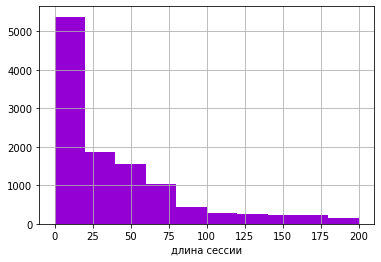

In [17]:
train_data_10users.session_timespan.hist(range=(0,200), color='darkviolet')
plt.xlabel('длина сессии')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

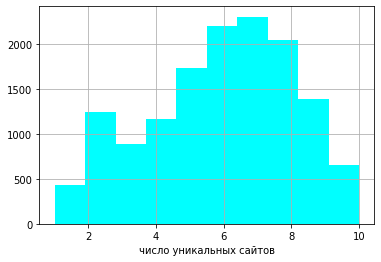

In [18]:
train_data_10users.unique_sites.hist(color='aqua')
plt.xlabel('число уникальных сайтов')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

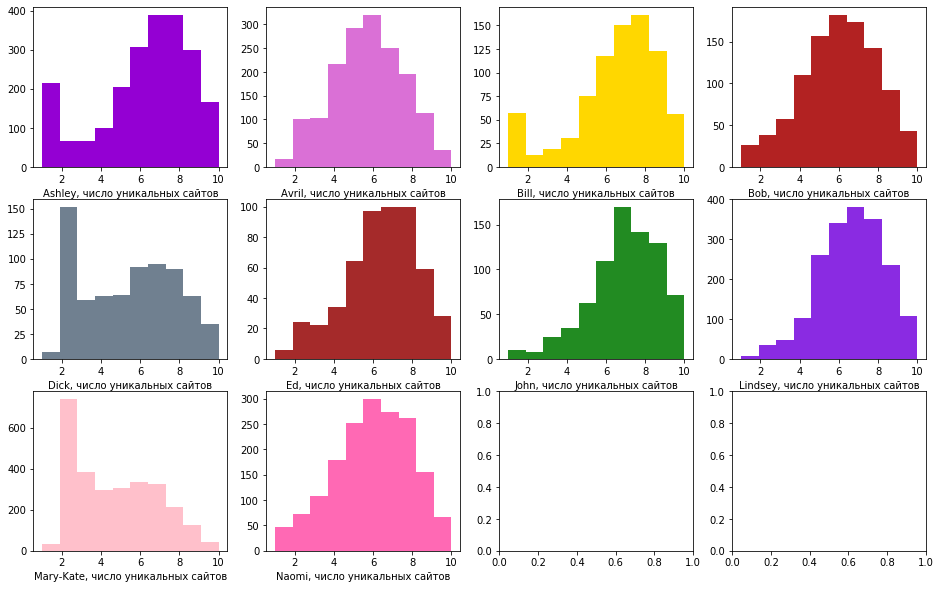

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('user_name')): 

    axes[idx//4, idx%4].hist(sub_df.unique_sites, color=color_dic[user])
    axes[idx//4, idx%4].set_xlabel(user + ', число уникальных сайтов')
    
plt.show()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

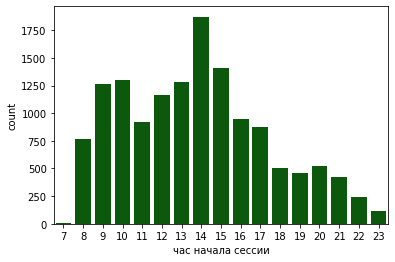

In [20]:
sns.countplot(train_data_10users.start_hour, color='darkgreen')
plt.xlabel('час начала сессии')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

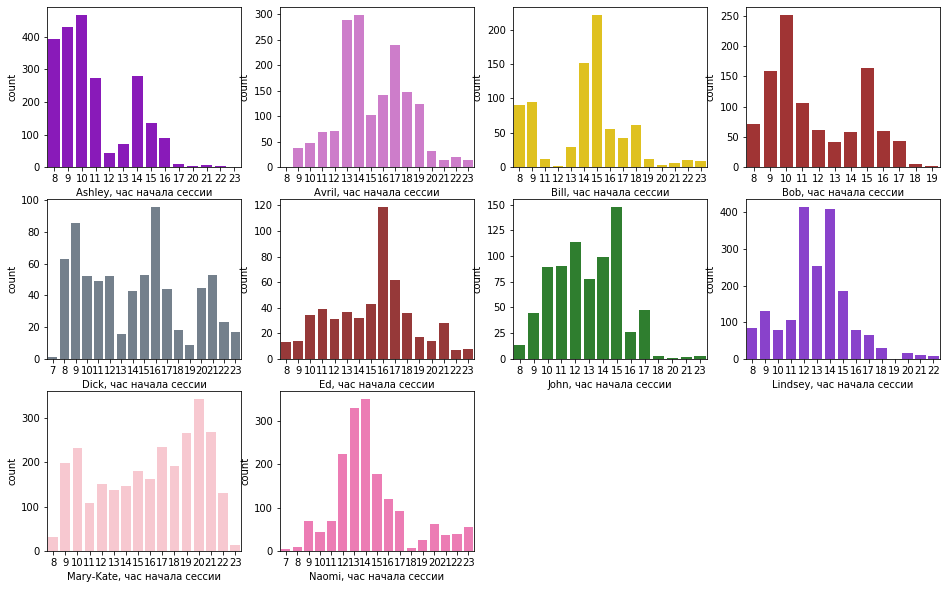

In [21]:
plt.figure(figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('user_name')): 

    plt.subplot(3, 4, idx+1)
    sns.countplot(sub_df.start_hour, color=color_dic[user])
    plt.xlabel(user + ', час начала сессии')
    
plt.show()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

In [22]:
day_of_week_names = {0 : 'пн', 1: 'вт', 2: 'ср', 3: 'чт', 4: 'пт', 5: 'сб', 6: 'вс'}

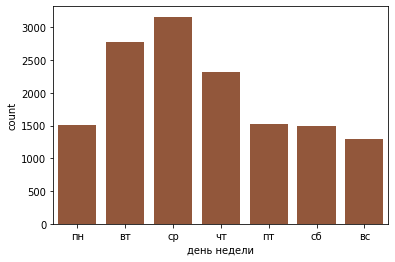

In [23]:
sns.countplot(train_data_10users.day_of_week, color='sienna')
plt.xlabel('день недели')
plt.xticks(np.arange(7), ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'])
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

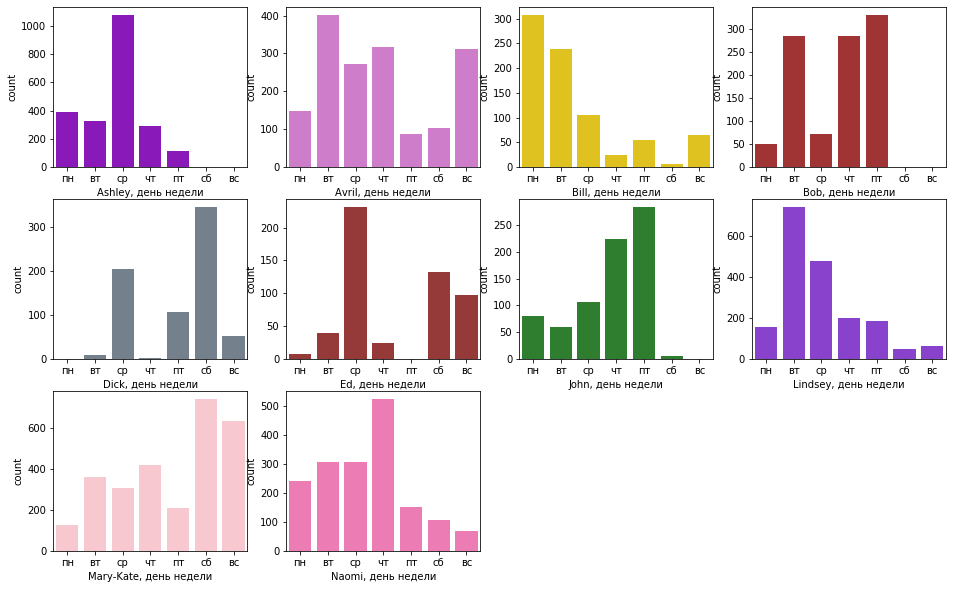

In [24]:
plt.figure(figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('user_name')): 

    plt.subplot(3, 4, idx+1)
    sns.countplot(sub_df.day_of_week, color=color_dic[user], order=np.arange(7))
    plt.xlabel(user + ', день недели')
    plt.xticks(np.arange(7), ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'])
    
plt.show()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Ashley: мода распределения числа уникальных сайтов в сессии приходится примерно на 7-8 сайтов, начало сессии как правило начинаются в утренние часы(с 8 до 11), есть сессии после полудня(14-16 часов), после 16 часов сессий мало. Предпочитает посещать веб-страницы по средам, не посещает на выходных.

Avril: мода распределения числа уникальных сайтов в сессии примерно на 6 сайтов, начало сессии как правило начинаются в 13-19 часов, распределение по часу начала бимодальное, наибольшее количество сессий приходится на 13-14 часов, есть пик в 17 часов. Чаще всего посещает веб-страницы во вторник, среду, четверг и воскресенье, в остальные дни посещений меньше.

Bill: мода распределения числа уникальных сайтов в сессии приходится примерно  на 8 сайтов, сессии как правило начинаются в 8-9 часов и с 14 до 18 часов, распределение бимодальное. Количество сессий уменьшается с увеличением номера дня недели, больше всего сессий приходится на понедельник.

Bob: мода распределения числа уникальных сайтов в сессии приходится примерно на 6 сайтов, распределение по часу начала бимодальное, с пиками 10 и 15 часов, предпочитает начинать сессию в утренние часы. Чаще всего посещает веб-страницы во вторник, четверг и пятницу, не посещает на выходных.

Dick: больше всего сессий с 2 уникальными сайтами, распределение по часу начала сессии имеет колебания в течении дня, с пиками в 9, 16 и 21 час и провалами в 13 и 19 часов. Относительно много сессий в вечернии часы(после 20 часов). Очень мало сессий в понедельник, вторник и четверг, большинство сессий приходится на субботу и среду.

Ed: мода распределения числа уникальных сайтов в сессии примерно 6-8 сайтов, большинство сессий приходится на 16-17 часов, по остальным часам сессии распределены более-менее равномерно. Нет сессий в пятницу, мало сессий в понедельник, вторник и четверг, больше всего сессий в среду, много сессий на выходных.

John: мода распределения числа уникальных сайтов в сессии примерно 7 сайтов. Большинство сессий начинается в 10-15 часов, пик распределения приходится на 15 часов. Очень мало сессий после 18 часов. В будние дни число сессий возрастает с номером дня, но на выходных сессий почти нет.

Lindsey: мода распределения числа уникальных сайтов в сессии примерно 7 сайтов. Большая часть сессий приходится на 12-15 часов, в 8-11 часов и 16-18 часов сессий значительно меньше, после 18 сессий очень мало. В понедельник сессий мало, большинство сессий приходится на вторник, затем число сессий убывает.

Mary-Kate: больше всего сессий с 2 уникальными сайтами. В 9-10 часов довольно много сессий, в 11 часам число сессий падает, затем с 11 до 20 возрастает с пиком в 20 часов. Большинство сессий в вечерние часы приходится на этого пользователя. В выходные дни количество сессий самое большое, в будние дни предпочитает начинать сессии во вторник, среду и четверг

Naomi: мода распределения числа уникальных сайтов в сессии примерно 6 сайтов. Большинство сессий приходится на 12-15 часов, пик в 14 часов. Сессии как правило начинаются с понедельника по четверг, с большинством сессий в четверг, с пятницы по воскресенье сессий значительно меньше. 

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей.**

In [27]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    site_freq = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [50]:
from collections import OrderedDict
site_freq = OrderedDict(sorted(site_freq.items(), key=lambda t: t[1][1], reverse=True))
top10_sites = list(site_freq.keys())[:10]
top10_freq = [site_freq[site][1] for site in top10_sites]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

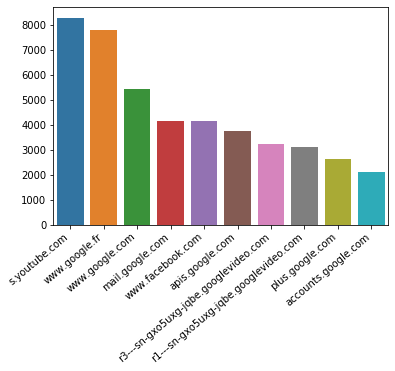

In [54]:
sns.barplot(x=top10_sites, y = top10_freq)
plt.xticks(rotation=40, ha="right")
plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

Рассмотрим следующий набор признаков:
- year_month - год и месяц начала сессии
- year_month_weekday - год, месяц и день недели начала сессии
- daytime - время суток в начале сессии(с 7 до 12 включительно - утро; с 13 до 16 - день; с 17 до 20 - вечер; все остальное - ночь)
- year_month_daytime - год, месяц и время суток начала сессии
- weekday_daytime - день недели и время суток начала сессии
- site_hour - час первого посещения определенного сайта в сессии. Если сайт не посещался, то значение признака равно -1

In [143]:
import copy

In [275]:
def feature_engineering(path_to_csv_files, site_freq_path, site_set, session_length=10, window_size=10):
    
    csv_files_list = glob(path_to_csv_files + '/*.csv')
    
    if type(site_freq_path) == str:
        with open(site_freq_path, 'rb') as f:
            site_freq = pickle.load(f)
    else:
        site_freq = site_freq_path
    
    site_freq.update({None : (0,0)})
    
    data_dict = dict() 
    site_cols = ['site' + str(x) for x in range(1, session_length+1)]    
    time_cols = ['time' + str(x) for x in range(1, session_length+1)]
    for site_col, time_col  in zip(site_cols, time_cols):
        data_dict.update({site_col : []})
        data_dict.update({time_col : []})
        
    data_dict.update({'session_timespan' : []})
    data_dict.update({'unique_sites' : []})
    data_dict.update({'start_hour' : []})
    data_dict.update({'day_of_week' : []})
    data_dict.update({'date' : []})
    data_dict.update({'month' : []})
    data_dict.update({'year' : []})
    data_dict.update({'year_month' : []})
    data_dict.update({'year_month_weekday' : []})
    data_dict.update({'daytime' : []})
    data_dict.update({'year_month_daytime' : []})
    data_dict.update({'weekday_daytime' : []})
    
    for site in site_set:
        data_dict.update({site + '_hour' : []})
        data_dict.update({site + '_weekday' : []})
    
    data_dict.update({'user_id' : []})
        
    
    for csv_file in tqdm(csv_files_list):
        raw_data = pd.read_csv(csv_file, index_col='timestamp', parse_dates=['timestamp'])
        
        len_prev = len(data_dict['site1'])

        for window in sliding_window(zip(raw_data.site, raw_data.index), session_length, window_size):
           # print(sites_window.index)
            temp_site_set_1 = set()
            temp_site_set_2 = copy.deepcopy(site_set)
            for site_col, time_col, elem in zip(site_cols, time_cols, window):
                try:
                    data_dict[site_col].append(site_freq[elem[0]][0])
                    data_dict[time_col].append(elem[1])
                    if elem[0] in temp_site_set_2:
                        data_dict[elem[0]+'_hour'].append(elem[1].hour)
                        data_dict[elem[0]+'_weekday'].append(elem[1].weekday())
                        temp_site_set_2.remove(elem[0])
                    temp_site_set_1.add(elem[0])
                except TypeError:
                    data_dict[site_col].append(0)
                    data_dict[time_col].append(None)
            
            for site in temp_site_set_2:
                data_dict[site+'_hour'].append(-1)
                data_dict[site+'_weekday'].append(-1)
            i = -1
            while True:
                try:
                    delta = window[i][1] - window[0][1]
                    break
                except TypeError:
                    i -= 1 
            data_dict['unique_sites'].append(len(set(temp_site_set_1)))
            data_dict['session_timespan'].append(delta.days * 86400 + delta.seconds)
            hour, weekday, month, year = window[0][1].hour, window[0][1].weekday(), window[0][1].month, window[0][1].year
            data_dict['start_hour'].append(hour)
            data_dict['day_of_week'].append(weekday)
            data_dict['date'].append(window[0][1].date())
            data_dict['month'].append(month)
            data_dict['year'].append(year)
            data_dict['year_month'].append(year * 100 + month)
            data_dict['year_month_weekday'].append(year * 1000 + month * 10 + weekday )
            if hour >= 7 and hour <= 12:
                data_dict['daytime'].append('morning')
                data_dict['year_month_daytime'].append(str(year * 100 + month)  + 'morning')
                data_dict['weekday_daytime'].append(str(weekday) + 'morning')
            elif hour >= 13 and hour <= 16:
                data_dict['daytime'].append('day')
                data_dict['year_month_daytime'].append(str(year * 100 + month)  + 'day')
                data_dict['weekday_daytime'].append(str(weekday) + 'day')
            elif hour >= 17 and hour <= 20:
                data_dict['daytime'].append('evening')
                data_dict['year_month_daytime'].append(str(year * 100 + month)  + 'evening')
                data_dict['weekday_daytime'].append(str(weekday) + 'evening')
            else:
                data_dict['daytime'].append('night')
                data_dict['year_month_daytime'].append(str(year * 100 + month)  + 'night')
                data_dict['weekday_daytime'].append(str(weekday) + 'night')

         
        user_id = int(csv_file[len(path_to_csv_files) + 5:-4])
        data_dict['user_id'] = data_dict['user_id'] + (len(data_dict['site1']) - len_prev) * [user_id]
    

    data = pd.DataFrame(data_dict)
    
    for time_col, time_col_prev in zip(time_cols[1:], time_cols[:-1]):
        data[time_col].fillna(value=data[time_col_prev], inplace=True)
    
    return data

В качестве сайтов, часы посещения которых нас интересуют, рассмотрим s.youtube.com, www.google.fr, www.facebook.com

In [276]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), 
                                           os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 
                                           {'s.youtube.com', 'www.google.fr', 'www.facebook.com'},
                                            session_length=10, window_size=10)

In [277]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), 
                                            os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'), 
                                            {'s.youtube.com', 'www.google.fr', 'www.facebook.com'},
                                            session_length=10, window_size=10)


Wall time: 25.3 s


In [278]:
new_features_10users.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,...,year_month,year_month_weekday,daytime,year_month_daytime,weekday_daytime,www.google.fr_hour,www.google.fr_weekday,s.youtube.com_hour,s.youtube.com_weekday,www.facebook.com_hour,www.facebook.com_weekday,user_id
0,193,2013-11-15 08:12:07,576,2013-11-15 08:12:17,133,2013-11-15 08:12:17,3,2013-11-15 08:12:17,133,2013-11-15 08:12:18,133,2013-11-15 08:12:38,...,201311,2013114,morning,201311morning,4morning,-1,-1,-1,-1,-1,-1,31
1,422,2013-11-15 08:12:40,192,2013-11-15 08:12:41,702,2013-11-15 08:12:41,256,2013-11-15 08:15:24,133,2013-11-15 08:17:09,31,2013-11-15 08:17:09,...,201311,2013114,morning,201311morning,4morning,-1,-1,-1,-1,-1,-1,31
2,55,2013-11-15 08:17:25,3,2013-11-15 08:17:25,55,2013-11-15 08:17:39,55,2013-11-15 08:17:40,5,2013-11-15 08:21:42,293,2013-11-15 08:21:42,...,201311,2013114,morning,201311morning,4morning,-1,-1,-1,-1,8,4,31
3,483,2013-11-15 08:21:43,3439,2013-11-15 08:21:45,483,2013-11-15 08:21:46,55,2013-11-15 08:21:46,55,2013-11-15 08:21:47,55,2013-11-15 08:22:12,...,201311,2013114,morning,201311morning,4morning,-1,-1,-1,-1,-1,-1,31
4,349,2013-11-15 08:22:13,55,2013-11-15 08:22:14,5,2013-11-15 08:22:14,4156,2013-11-15 08:22:15,258,2013-11-15 08:22:16,211,2013-11-15 08:22:17,...,201311,2013114,morning,201311morning,4morning,-1,-1,-1,-1,8,4,31


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [279]:
new_features_10users['user_name'] = new_features_10users['user_id'].map(id_name_dict)

Сначала построим графики для признака year_month

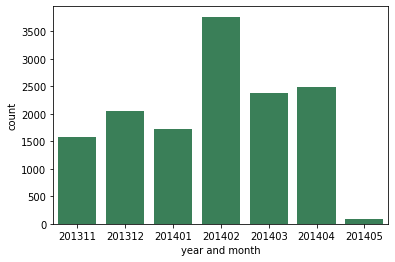

In [280]:
sns.countplot(new_features_10users.year_month, color='seagreen')
plt.xlabel('year and month')
plt.show()

Для отдельных пользователей:

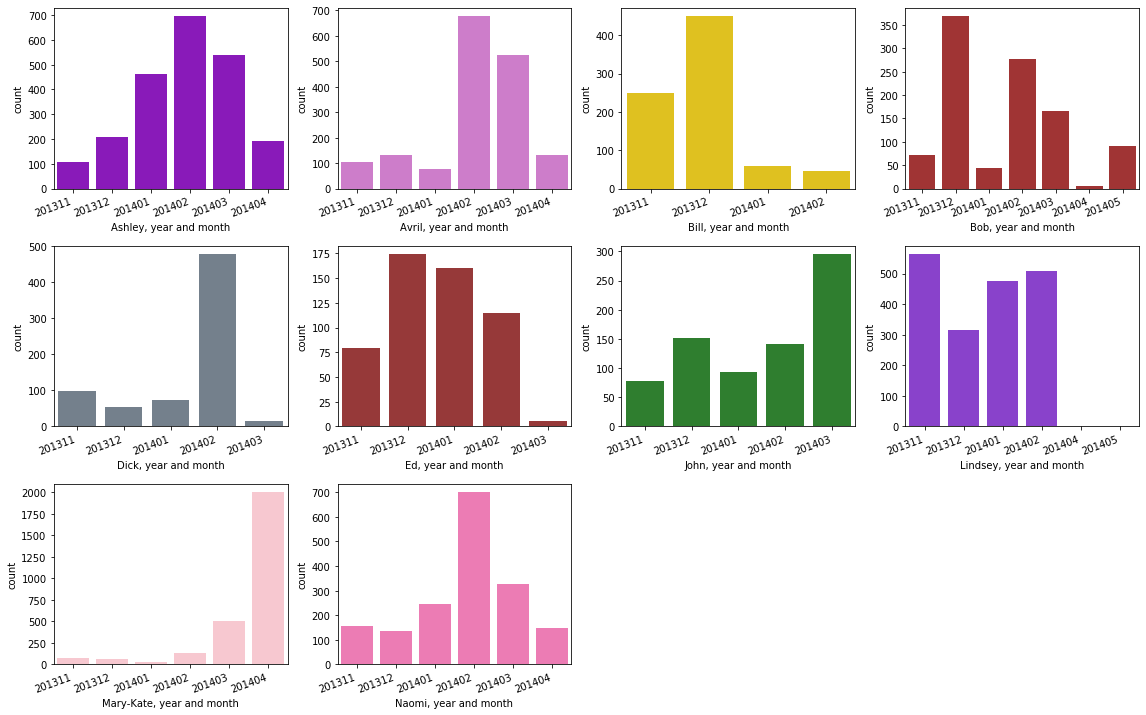

In [281]:
plt.figure(figsize=(16,10))
for idx, (user, sub_df) in enumerate(new_features_10users.groupby('user_name')):
    plt.subplot(3, 4, idx+1)
    sns.countplot(sub_df.year_month, color=color_dic[user])
    plt.xticks(rotation=20, ha="right")
    plt.xlabel(user + ', year and month')
plt.tight_layout(1)

Мы видим, что поведение пользователей существенно меняется в зависимости от месяца. Например, у пользователя Dick больше всего сессий в феврале 2014 и значительно меньше сессий в остальные месяцы.

Теперь построим графики для признака year_month_weekday. Для этого воспользуемся catplot из seaborn:

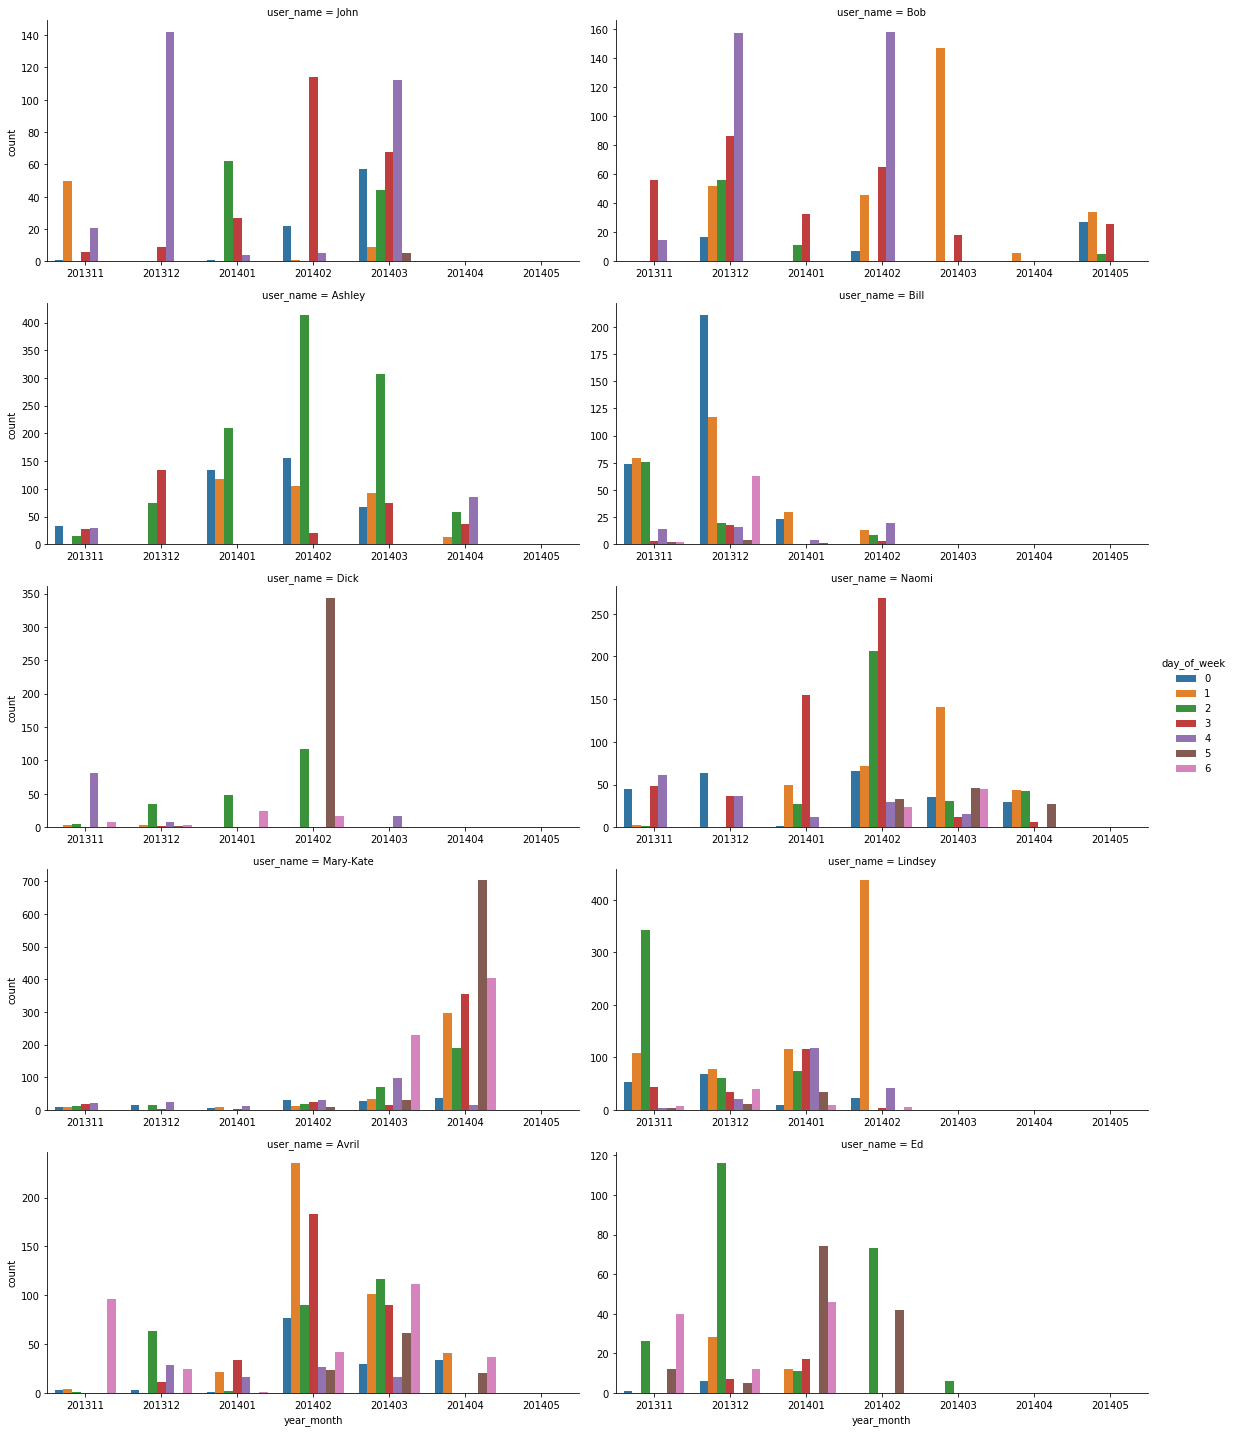

In [283]:
sns.catplot(x='year_month', hue='day_of_week', col='user_name', col_wrap=2, height=4, aspect=2,
            data=new_features_10users, kind='count', sharey=False, sharex=False)
plt.show()

Распределение по дням недели значительно изменятся в зависимости от месяца. Графики для признака daytime:

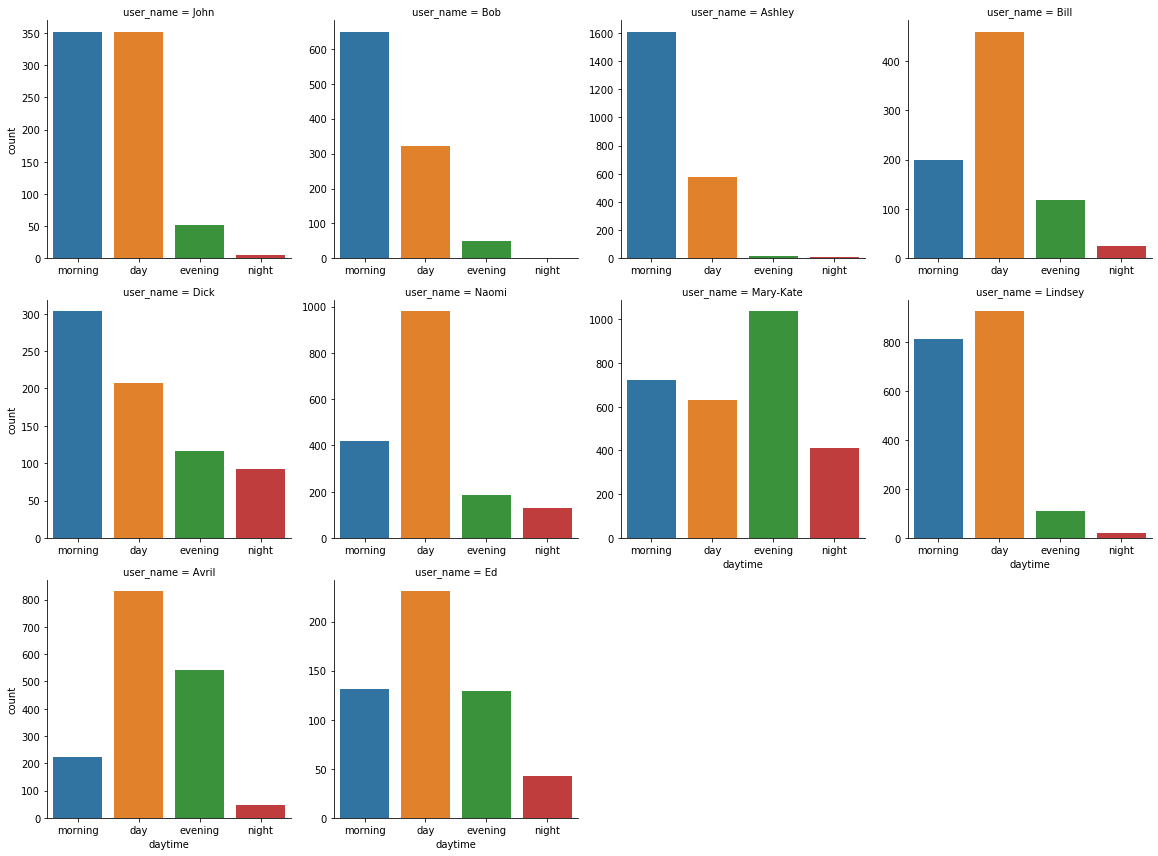

In [293]:
sns.catplot(x='daytime', col='user_name', col_wrap=4, height=4, aspect=1,
            data=new_features_10users, kind='count', sharey=False, sharex=False)
plt.show()

И графики для признаков year_month_daytime и weekday_daytime:

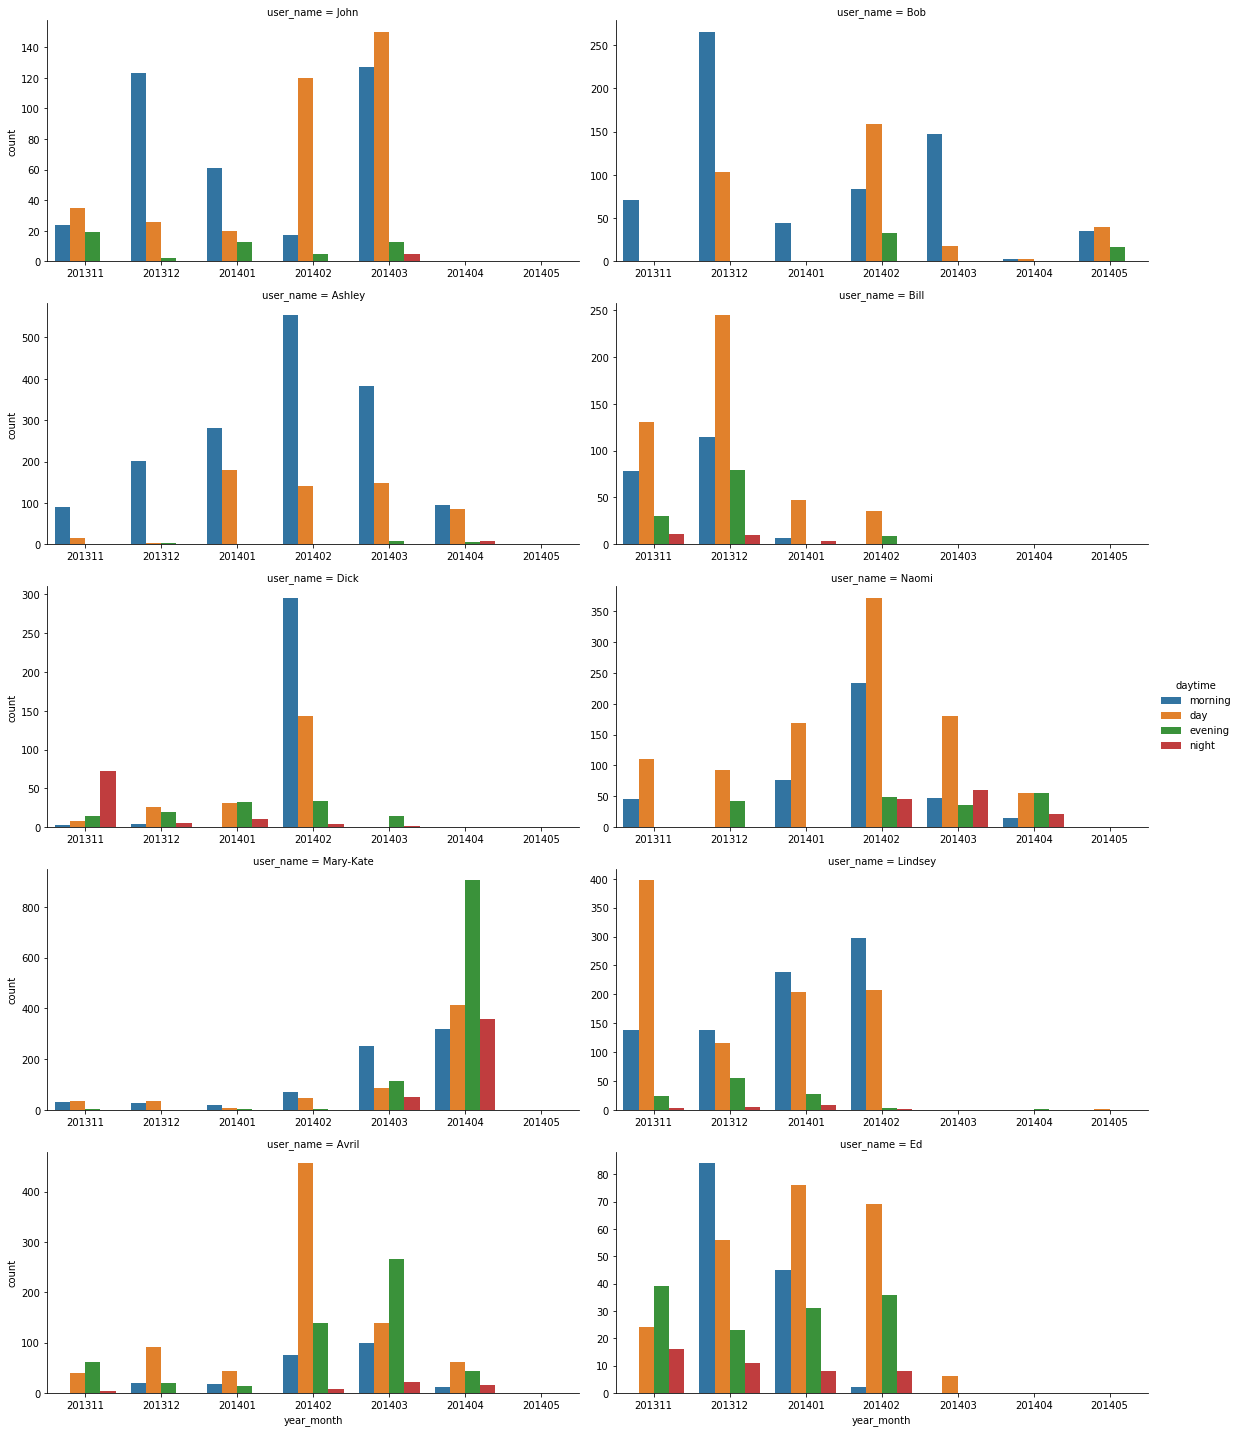

In [284]:
sns.catplot(x='year_month', hue='daytime', col='user_name', col_wrap=2, height=4, aspect=2,
            data=new_features_10users, kind='count', sharey=False, sharex=False)
plt.show()

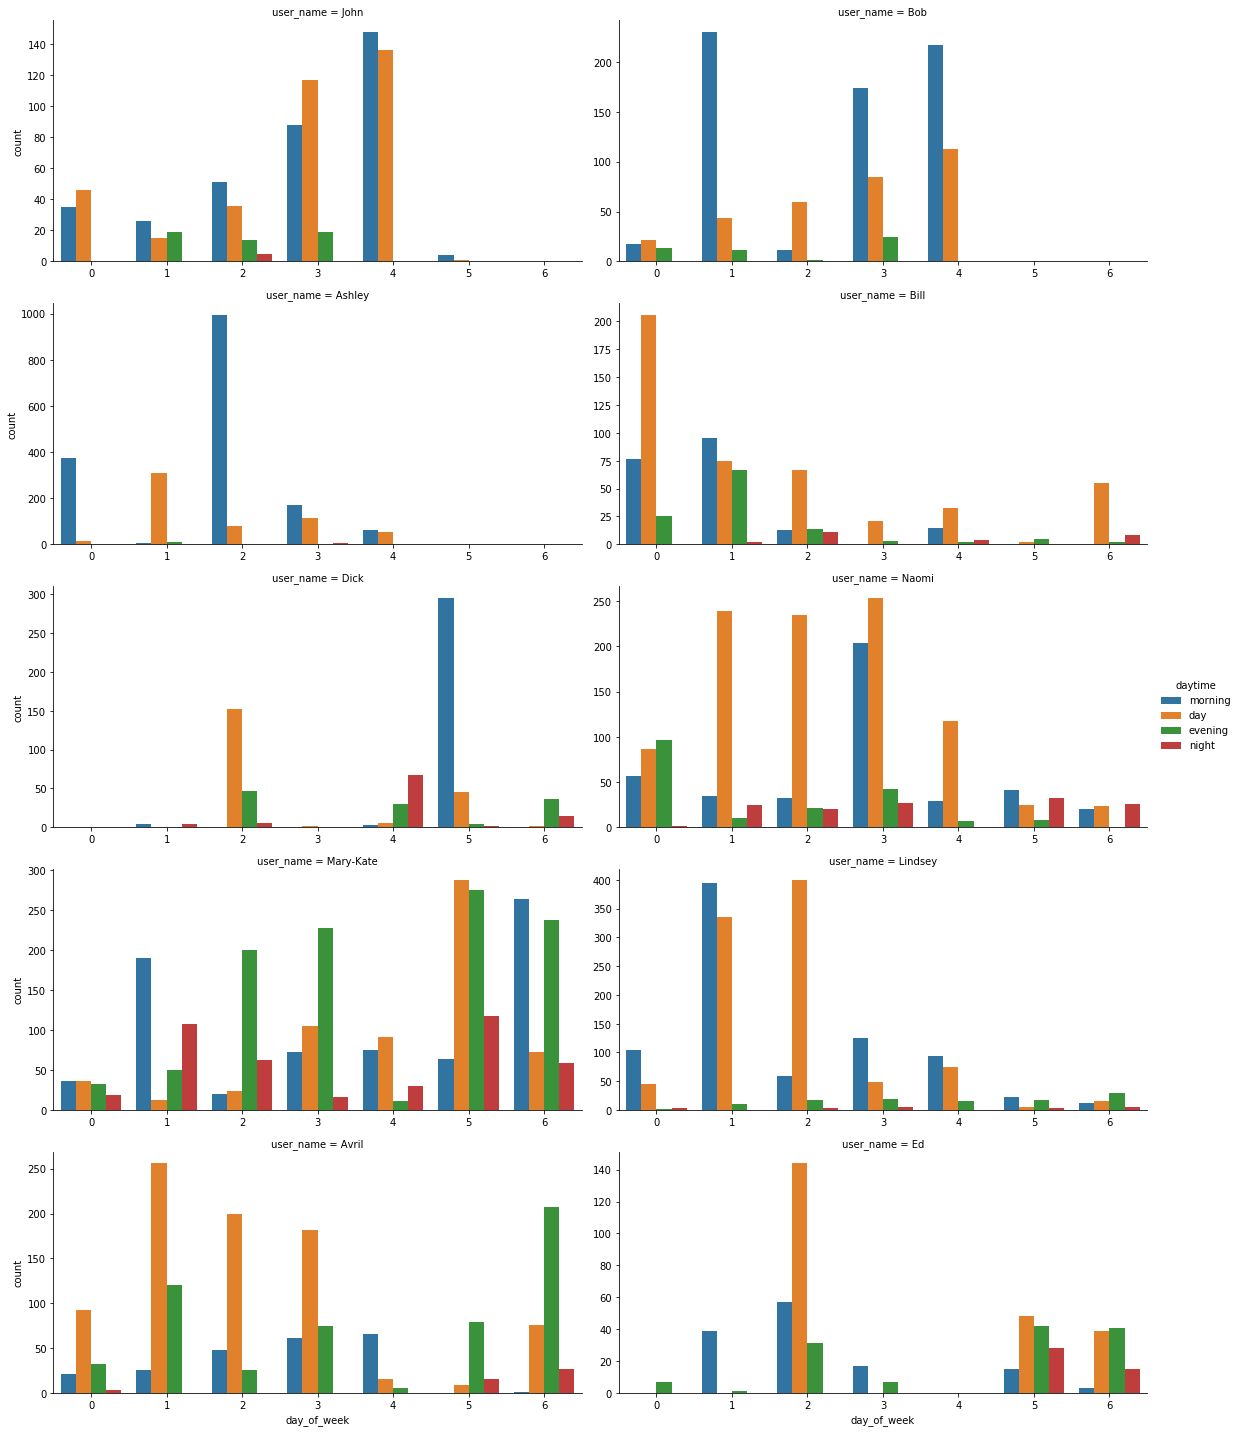

In [288]:
sns.catplot(x='day_of_week', hue='daytime', col='user_name', col_wrap=2, height=4, aspect=2,
            data=new_features_10users, kind='count', sharey=False, sharex=False)
plt.show()

Время суток посещения изменяется в зависимости от дня недели и месяца посещения. 

Графики для признаков site_hour. Сравним эти графики с распределением по часу начала сессии:

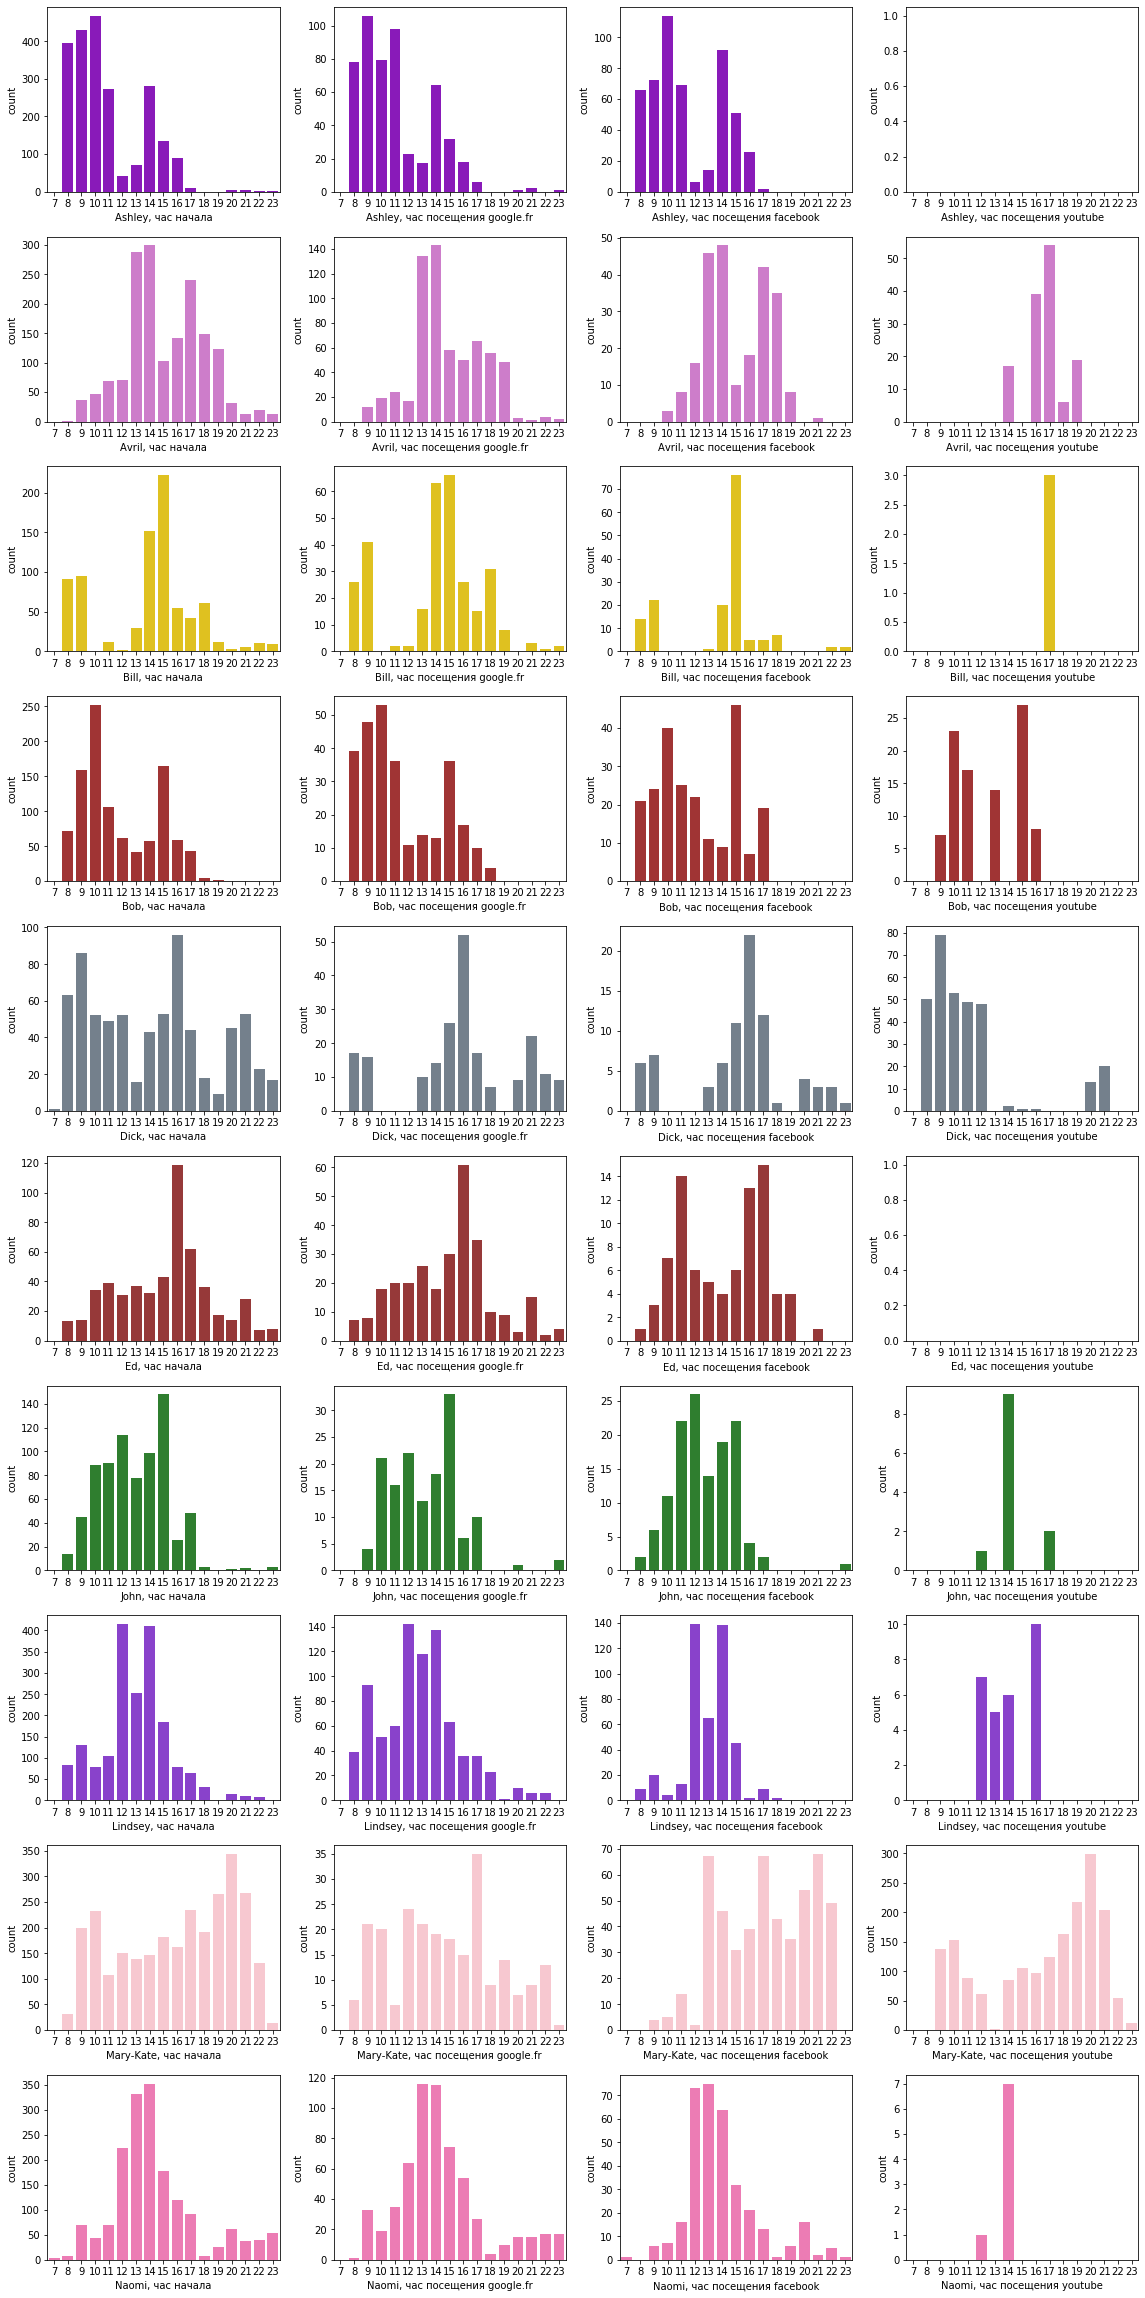

In [311]:
plt.figure(figsize=(16,32))
min_hour = new_features_10users.start_hour.min()
max_hour = new_features_10users.start_hour.max() + 1
for idx, (user, sub_df) in enumerate(new_features_10users.groupby('user_name')):
    plt.subplot(10,4,idx*4+1)
    sns.countplot(sub_df.start_hour, color=color_dic[user], order=np.arange(min_hour, max_hour))
    plt.xlabel(user + ', час начала')

    plt.subplot(10,4,idx*4+2)
    sns.countplot(sub_df[sub_df['www.google.fr_hour']!=-1]['www.google.fr_hour'], 
                  color=color_dic[user], order=np.arange(min_hour, max_hour))
    plt.xlabel(user + ', час посещения google.fr')

    plt.subplot(10,4,idx*4+3)
    sns.countplot(sub_df[sub_df['www.facebook.com_hour']!=-1]['www.facebook.com_hour'], 
                  color=color_dic[user], order=np.arange(min_hour, max_hour))
    plt.xlabel(user + ', час посещения facebook')

    plt.subplot(10,4,idx*4+4)
    sns.countplot(sub_df[sub_df['s.youtube.com_hour']!=-1]['s.youtube.com_hour'], 
                  color=color_dic[user], order=np.arange(min_hour, max_hour))
    plt.xlabel(user + ', час посещения youtube')
    
plt.tight_layout(1)

Распределения по часу посещения определенных сайтов для некоторых пользователей существенно отличаются от распределенией по часу начала сессии, поэтому эти признаки также могут помочь в задаче идентификации пользователей.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [313]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(new_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(new_features_150users, selected_features_150users_pkl, 
                protocol=2)